In [149]:
# Quick hack to fix local imports
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#### Get Input Datasets

In [150]:
import pyrosm
import geopandas
import numpy as np
import pandas as pd
import rasterio
import rioxarray as rxr
from matplotlib import pyplot as plt
from shapely.geometry import mapping, box, LineString
from rasterio.crs import CRS

In [3]:
OUT_CRS = CRS.from_epsg(27700)  # https://epsg.io/27700

In [4]:
# Get London's OpenStreetMap data
fp = pyrosm.get_data("London", update=True)

Downloaded Protobuf data 'London.osm.pbf' (68.55 MB) to:
'/tmp/pyrosm/London.osm.pbf'


In [38]:
# # Initialize the OSM object 
# osm = pyrosm.OSM(fp)
# # Read all boundaries using the default settings
# boundary = osm.get_boundaries()

# # pick a small subset for testing
# boundary = osm.get_boundaries(name="London Borough of Tower Hamlets")

# bbox = box(-0.04, 51.48, 0.011, 51.52)  # a random box around a part of Tower Hamlets and Canary Wharf
# boundary = geopandas.GeoDataFrame({'geometry': bbox}, index=[0])

bbox = box(-0.161,51.449,-0.002,51.529)  # a random box containing City of London and some of South London like Brixton
boundary = geopandas.GeoDataFrame({'geometry': bbox}, index=[0])

In [39]:
%%time
uk_wp = rxr.open_rasterio('../data/gbr_ppp_2020_UNadj_constrained.tif', masked=True).squeeze()
print(uk_wp.rio.crs)  # make sure the crs is EPSG:4326 (WGS84) to match the unprojected OSM boundary
wp_clipped = uk_wp.rio.clip(boundary.geometry.apply(mapping))

EPSG:4326
CPU times: user 1.92 s, sys: 5.89 s, total: 7.81 s
Wall time: 7.85 s


In [40]:
# Get the shapely geometry from GeoDataFrame
bbox_geom = boundary['geometry'].values[0]

# Initialise with bounding box
osm = pyrosm.OSM(fp, bounding_box=bbox_geom)

In [41]:
%%time
# get all residential buildings as well as ones without a specific tag
residential_filter = {"building": ["residential", "apartments", "flats", "house", "yes"]}
residential_buildings = osm.get_buildings(custom_filter=residential_filter)

CPU times: user 27.9 s, sys: 4.33 s, total: 32.2 s
Wall time: 32.2 s


In [42]:
%%time
# crudely get all places that might be considered workplaces
pois_filter = {"shop": True,"amenity": True, "leisure": True, "tourism": True}
pois = osm.get_pois(custom_filter=pois_filter)
office_filter = {"office": True}
offices = osm.get_data_by_custom_criteria(custom_filter=office_filter)
office_building_filter = {"building": ["office", "offices"]}
office_buildings = osm.get_buildings(custom_filter=office_building_filter)

CPU times: user 6.81 s, sys: 500 ms, total: 7.31 s
Wall time: 7.33 s


In [43]:
%%time
# combine the locations of all of the crude workplaces
trimmed_households = residential_buildings[['geometry']]
trimmed_work = pois[['geometry']]
trimmed_offices = offices[['geometry']]
trimmed_office_buildings = office_buildings[['geometry']]
trimmed_work = trimmed_work.append(trimmed_offices).append(trimmed_office_buildings)
trimmed_work = trimmed_work.reset_index()
trimmed_work['geometry'] = trimmed_work.geometry.centroid

CPU times: user 93.8 ms, sys: 15.6 ms, total: 109 ms
Wall time: 118 ms


<timed exec>:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



In [44]:
# get all walking networks
# walk_net = osm.get_network(network_type="walking")
# walk_net.plot()

In [45]:
# get all cycling networks
# bike_net = osm.get_network(network_type="cycling")
# bike_net.plot()

In [46]:
# get all road networks
# drive_net = osm.get_network(network_type="driving+service")
# drive_net.plot()

In [47]:
%%time
# get all public transport
edges = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/edges.csv')
nodes = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/nodes.csv')
nodes = geopandas.GeoDataFrame(nodes, geometry=geopandas.points_from_xy(nodes.lon, nodes.lat))
layers = pd.read_csv('../data/uk_aggregate/Data_Release_v1.11/layers.csv')

# Clip the nodes to the boundary
clipped_nodes = geopandas.clip(nodes, boundary)
# Only select edges that start or end at the clipped nodes
des_edges = edges[edges.rename(columns={'des_node': 'node', 'des_layer': 'layer'}).set_index(['node', 'layer']).index.isin(clipped_nodes.set_index(['node', 'layer']).index)]
ori_edges = edges[edges.rename(columns={'ori_node': 'node', 'ori_layer': 'layer'}).set_index(['node', 'layer']).index.isin(clipped_nodes.set_index(['node', 'layer']).index)]
edges = des_edges.append(ori_edges)

CPU times: user 2.09 s, sys: 109 ms, total: 2.2 s
Wall time: 2.2 s


In [51]:
%%time
# Draw lines for the edges
old_index = nodes.index
nodes = nodes.set_index(['node', 'layer'])
edges = geopandas.GeoDataFrame(edges, geometry=edges.apply(lambda x: LineString([nodes.loc[(x.ori_node, x.ori_layer)].geometry, nodes.loc[(x.des_node, x.des_layer)].geometry]), axis=1))
nodes = nodes.reset_index()
nodes.index = old_index

# Clip those edges to the boundary too
clipped_new_edges = geopandas.clip(edges.reset_index(), boundary)

Number of nodes: 881, edges: 5475
CPU times: user 4.28 s, sys: 0 ns, total: 4.28 s
Wall time: 4.29 s


Total Population: 1170636
Buildings from OSM, Residential: 78436, Workplaces: 41351
Public transport graph, nodes: 881, edges: 5475
CPU times: user 25.3 s, sys: 234 ms, total: 25.5 s
Wall time: 25.3 s


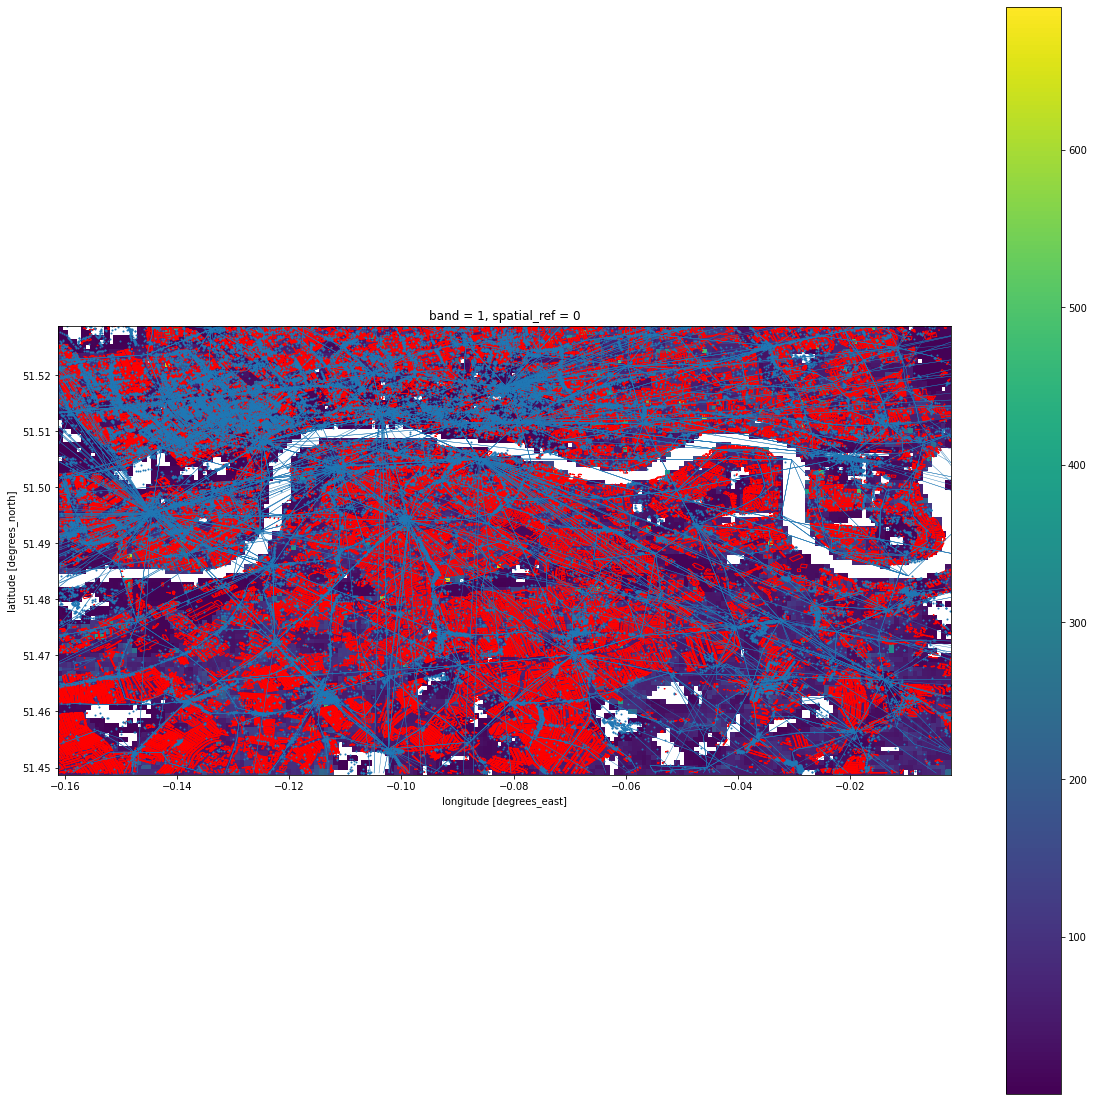

In [61]:
%%time
fig, ax = plt.subplots(figsize=(20, 20))
wp_clipped.plot(ax=ax)
residential_buildings.plot(ax=ax, facecolor='none', edgecolor='r')
trimmed_work.plot(ax=ax, markersize=1)
clipped_new_edges[~clipped_new_edges.is_empty].plot(ax=ax, linewidth=0.4)
print(f"Total Population: {int(wp_clipped.sum())}")
print(f"Buildings from OSM, Residential: {len(residential_buildings)}, Workplaces: {len(trimmed_work)}")
print(f"Public transport graph, nodes: {len(clipped_nodes)}, edges: {len(clipped_new_edges)}")
del fig, ax

#### Build Model

In [165]:
import generated.OutbreakSim.Model.Model as gen_model
import generated.OutbreakSim.Model.Agents as gen_agents
import generated.OutbreakSim.Model.Households as gen_households
import generated.OutbreakSim.Model.Vec2 as gen_vec2

import random
from pathlib import Path
from enum import IntEnum
from collections import defaultdict
from typing import Tuple

import flatbuffers

import pandas as pd
from scipy.spatial import cKDTree
import scipy.stats as stats

from geopy import distance

In [63]:
projected_boundary = boundary.copy()
projected_boundary = projected_boundary.set_crs("EPSG:4326")
projected_boundary = projected_boundary.to_crs(OUT_CRS)
bounds = projected_boundary.bounds
boundary_minx = bounds.loc[bounds.index[0], 'minx']
boundary_maxx = bounds.loc[bounds.index[0], 'maxx']
boundary_miny = bounds.loc[bounds.index[0], 'miny']
boundary_maxy = bounds.loc[bounds.index[0], 'maxy']
    
def convert_to_x_y(in_df):
    out_df = in_df.to_crs(OUT_CRS)
    out_df['x'] = out_df.geometry.centroid.x
    out_df['y'] = out_df.geometry.centroid.y
    out_df['x'] = (out_df['x'] - boundary_minx) / (boundary_maxx - boundary_minx)
    out_df['y'] = (out_df['y'] - boundary_miny) / (boundary_maxy - boundary_miny)
    return out_df[['x', 'y']]

In [166]:
# inspired by https://gis.stackexchange.com/a/301935
def cKDQueryRadius(gdA_in, gdB_in, radius=300, reproject=True, p=2.0, workers=1):
    gdA = gdA_in.copy()
    gdB = gdB_in.copy()
    if reproject:
        in_crs = gdA.crs
        gdA = gdA.to_crs(OUT_CRS)
        gdB = gdB.to_crs(OUT_CRS)
        
    nA = np.array(list(gdA.geometry.centroid.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.centroid.apply(lambda x: (x.x, x.y))))
    
    btree = cKDTree(nB)
    elements_in_radius = btree.query_ball_point(nA, r=radius, p=p, workers=workers)

    gdf = pd.concat(
        [gdA.reset_index(drop=True),
        pd.Series(elements_in_radius, name='Elements in Radius')], axis=1
    )
    if reproject:
        gdf = gdf.to_crs(gdA_in.crs)
    return gdf

In [84]:
%%time
nx, ny = wp_clipped.sizes['x'], wp_clipped.sizes['y']
x, y = wp_clipped.rio.transform() * np.meshgrid(np.arange(nx)+0.5, np.arange(ny)+0.5)

# GeoDataFrame of centres of raster cells, indexed by their respective ravelled index
raster_coords = geopandas.GeoDataFrame({'ravelled_index': np.arange(x.size)}, geometry=geopandas.points_from_xy(x.ravel(), y.ravel()), crs="EPSG:4326")
residences_in_radius = cKDQueryRadius(raster_coords, residential_buildings)

CPU times: user 6.72 s, sys: 172 ms, total: 6.89 s
Wall time: 6.92 s


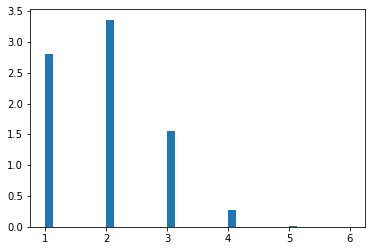

In [85]:
lower, upper = 1, 8
mu, sigma = 2.2, 0.98

household_size_dist = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)  # TODO Replace according to research https://www.statista.com/statistics/281627/households-in-the-united-kingdom-uk-by-size/
fig, ax = plt.subplots(1, 1)
ax.hist(household_size_dist.rvs(100_000).astype(int), density=True, bins=40)
plt.show()
del fig, ax

In [86]:
class Person():
    def __init__(self, uid, household_uid, age, pos):
        self.uid = uid
        self.household_uid = household_uid
        self.age = age
        self.pos = pos
        

people = []

def add_new_person(household_uid, pos):
    age = random.randint(0, 108)  # Todo update this
    
    new_person = Person(uid=len(people), household_uid=household_uid, age=age, pos=pos)
    people.append(new_person)
    
    return new_person

In [95]:
class Household():
    def __init__(self, uid, max_inhabitants, pos: Tuple[float, float]):
        self.uid = uid
        self.inhabitants = 0
        self.max_inhabitants = max_inhabitants
        self.pos = pos
    
    def to_dict(self):
        return {
            'uid': self.uid,
            'inhabitants': self.inhabitants,
            'max_inhabitants': self.max_inhabitants,
            'pos': self.pos,
        }
    
households = []

def add_new_household(pos_geometry):
    max_inhabitants = household_size_dist.rvs(1)[0]
    
    new_household = Household(uid=len(households), max_inhabitants=max_inhabitants, pos=pos_geometry)
    households.append(new_household)
    
    return new_household

In [88]:
class ResidenceType(IntEnum):
    HOUSE = 0
    SMALL_FLATS = 1  # Perhaps a few floors or flats in one building
    LARGE_FLATS = 2  # Generally high-rise, shared lifts, etc.


residence_params = {
    'max_household_capacity': 7,
    ResidenceType.HOUSE: {
        'max_households': 2
    },
    ResidenceType.SMALL_FLATS: {
        'max_households': 10
    },
    ResidenceType.LARGE_FLATS: {
        'max_households': 150
    }
}

residential_buildings['residence_type'] = ResidenceType.HOUSE
residential_buildings.loc[residential_buildings['building'].isin(['apartments', 'flats']), 'residence_type'] = ResidenceType.SMALL_FLATS

### Household Allocation and Person Generation

In [89]:
%%time
# NOTE: Seems to grow roughly linearly with population
residences_to_households = defaultdict(lambda: [])
residential_buildings = residential_buildings.to_crs(OUT_CRS)

# reset lists
households = []
people = []
failures = 0

for row in range(wp_clipped.shape[0]):
    for col in range(wp_clipped.shape[1]):
        index = (row, col)
        people_at_tile = wp_clipped[row, col]
        
        if np.isnan(people_at_tile):
            continue
        
        local_residences_indices = residences_in_radius.loc[np.ravel_multi_index(index, wp_clipped.shape), 'Elements in Radius']
        
        for _ in range(int(people_at_tile)):
            shuffled_indices = np.random.permutation(local_residences_indices)

            chosen_household = None

            for residence_index in shuffled_indices:
                households_at_residence = [households[household_uid] for household_uid in residences_to_households[residence_index]]
                possible_households = [household for household in households_at_residence if household.inhabitants < household.max_inhabitants]

                if len(possible_households) != 0:
                    chosen_household = random.choice(possible_households)
                    chosen_household.inhabitants += 1
                    break
                else:
                    building_type = residential_buildings.loc[residence_index, 'residence_type']
                    
                    if len(households_at_residence) < residence_params[building_type]['max_households']:
                        pos = residential_buildings.loc[residence_index].geometry.centroid
                        chosen_household = add_new_household(pos)
                        residences_to_households[residence_index].append(chosen_household.uid)
                        
                        chosen_household.inhabitants += 1
                        
            else:  # failed to find an available household, or residence to make a new household in, so upgrade a residence 
                smaller_residences_indices = [residence_index for residence_index in local_residences_indices 
                                              if residential_buildings.loc[residence_index, 'residence_type'] != ResidenceType.LARGE_FLATS]
                
                if len(smaller_residences_indices) != 0:
                    chosen_residence_index = random.choice(smaller_residences_indices)
                    residential_buildings.loc[chosen_residence_index, 'residence_type'] = ResidenceType(residential_buildings.loc[chosen_residence_index, 'residence_type'] + 1)
                    
                    pos = residential_buildings.loc[chosen_residence_index].geometry.centroid
                    chosen_household = add_new_household(pos)
                    residences_to_households[chosen_residence_index].append(chosen_household.uid)
                else:
                        failures += 1
                        continue
#                     raise Exception("Bugger gotta deal with this")
            add_new_person(chosen_household.uid, chosen_household.pos)    
print(f"Failures: {failures}")

Failures: 2763
CPU times: user 20min 5s, sys: 391 ms, total: 20min 5s
Wall time: 20min 7s


### Workplace Allocation

In [91]:
def _get_commute_dist():
    mean = 30.0
    std_dev = 7.0
    size = 100_000
    distances = np.random.normal(mean, std_dev, size)  # TODO Update this to reflect actual distribution from research
    distance_iter = iter(distances)
    
    while True:
        if next(distance_iter, None) is None:
            distances = np.random.normal(mean, std_dev, size)  # refresh the distances
            distance_iter = iter(distances)
        yield next(distance_iter)

In [140]:
%%time
households_df = pd.DataFrame.from_records([h.to_dict() for h in households])
households_gdf = geopandas.GeoDataFrame(households_df, geometry=households_df['pos'], crs="EPSG:4326")
households_gdf.drop(['pos', 'max_inhabitants'], axis=1, inplace=True)

CPU times: user 16.6 s, sys: 359 ms, total: 16.9 s
Wall time: 17 s


<AxesSubplot:>

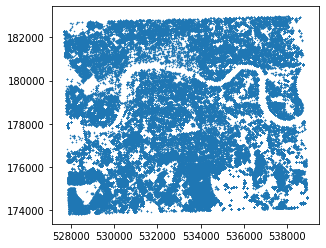

In [126]:
households_gdf.plot(markersize=0.1)

In [167]:
%%time
workplaces_in_radius = cKDQueryRadius(households_gdf, trimmed_work, radius=20_000, p=np.inf, workers=6)

TypeError: query_ball_point() got an unexpected keyword argument 'workers'

In [71]:
print(len(households))
print(len(people))

589786
1159580


In [72]:
for household in households:
    household.pos = (((household.pos.x - boundary_minx) / (boundary_maxx - boundary_minx)), 
                     ((household.pos.y - boundary_miny) / (boundary_maxy - boundary_miny)))

In [90]:
X = [household.pos[0] for household in households]
Y = [household.pos[1] for household in households]

plt.scatter(X, Y, markersize=0.2)

del X, Y

TypeError: 'Point' object is not subscriptable

In [74]:
# TODO, nonsense atm
AGENT_SIZE = 32  # in bytes
WORKPLACE_SIZE = 8  # in bytes
HOUSEHOLD_SIZE = 8  # in bytes
CONTAINER_SIZE = 8  # in bytes

initial_buffer_size = (int(wp_clipped.sum())
                       * AGENT_SIZE + len(trimmed_households) 
                       * HOUSEHOLD_SIZE + len(trimmed_work) 
                       * WORKPLACE_SIZE)
print(initial_buffer_size)

38418648


In [77]:
builder = flatbuffers.Builder(initial_buffer_size)

In [78]:
# Create `vectors` representing the attributes of the Agents SoA
# Note: Since we prepend the bytes, this loop iterates in reverse.
gen_agents.AgentsStartAgeVector(builder, len(people))
for i in reversed(range(0, len(people))):
    builder.PrependUint8(people[i].age)
agents_age_vec = builder.EndVector(len(people))

gen_agents.AgentsStartHouseholdIndexVector(builder, len(people))
for i in reversed(range(0, len(people))):
    builder.PrependUint32(people[i].household_uid)
agents_household_index_vec = builder.EndVector(len(people))

# gen.Model.Agents.AgentsStartWorkplaceIndexVector(builder, len(people))
# for i in reversed(range(0, len(people))):
#     builder.PrependUint32(people[i].workplace_uid)
# agents_workplace_index_vec = builder.EndVector(len(people))

gen_agents.AgentsStart(builder)
gen_agents.AgentsAddAge(builder, agents_age_vec)
gen_agents.AgentsAddHouseholdIndex(builder, agents_household_index_vec)
# gen.Agents.AgentsAddWorkplaceIndex(builder, agents_workplace_index_vec)
built_agents = gen_agents.AgentsEnd(builder)

In [79]:
# Create `vectors` representing the attributes of the Households SoA
# Note: Since we prepend the bytes, this loop iterates in reverse.
gen_households.HouseholdsStartPosVector(builder, len(households))
for i in reversed(range(0, len(households))):
    gen_vec2.CreateVec2(builder, households[i].pos[0], households[i].pos[1])
households_pos_vec = builder.EndVector(len(households))

gen_households.HouseholdsStart(builder)
gen_households.HouseholdsAddPos(builder, households_pos_vec)
built_households = gen_households.HouseholdsEnd(builder)

In [80]:
# Create Model
gen_model.ModelStart(builder)
gen_model.ModelAddAgents(builder, built_agents)
gen_model.ModelAddHouseholds(builder, built_households)
built_model = gen_model.ModelEnd(builder)
builder.Finish(built_model)
buf = builder.Output()

In [81]:
out_path = Path("./output/model_mid_south_london_1m.txt")
out_path.write_bytes(buf)

10516252